# Libraries

## Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
tf.keras.backend.set_floatx('float64')

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Built-in libraries

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import math
import time
import timeit
import pandas                                   as pd
import numpy                                    as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot                        as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
from   tensorflow.keras.models                  import Model
from   tensorflow.keras.models                  import Sequential
from   tensorflow.keras.layers                  import LSTM
from   tensorflow.keras.layers                  import RepeatVector 
from   tensorflow.keras.layers                  import Dense
from   tensorflow.keras.layers                  import TimeDistributed
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau
from   tensorflow.keras.metrics                 import *


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from   utils.BLAS                                     import create_dataset
from   utils.Evaluation                               import RegressionEvaluation
from   utils.PerformanceMetrics                       import *

# Parameters

In [3]:
#%%
# Parameters
filename   = 'Data/Temperature.csv'
SeriesName = 'Temperature'
#
Transformation  = 'Log' # 'Log', 'yeo-johnson', 'box-cox', 'None'
Scaling         = 'Standard'
#
Lag             = 48
Horizon         = 12



# Neural network parameters
#
epochs          =  200
batch_size      =  256

# Data handling

## Import data

In [4]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )


# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Data imported
[INFO] Time: 0.01 seconds


## Create new features based on Date/Time

In [5]:
df['Hour']     = df.index.hour
df['Minute']   = df.index.minute

# Training/Validation/Testing

In [6]:
# Create training/testing dfsets
#
train_idx = int( df.shape[0] * 0.8)
valid_idx = int( df.shape[0] * 0.9)


Training   = df.iloc[ :train_idx          ]
Validation = df.iloc[ train_idx:valid_idx ]
Testing    = df.iloc[ valid_idx:          ]

In [7]:
print('Training:   ',   Training.shape)
print('Validation: ', Validation.shape)
print('Testing:    ',    Testing.shape)

Training:    (7801, 3)
Validation:  (975, 3)
Testing:     (976, 3)


## Visualize Training, Validation and Testing Data

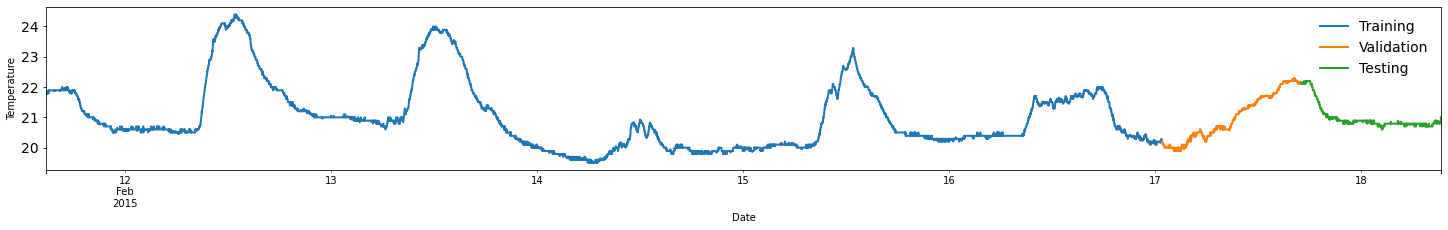

In [8]:
fig, ax = plt.subplots(figsize=(25, 3));
#
#
Training[SeriesName].plot(ax=ax, linewidth=2)
Validation[SeriesName].plot(ax=ax, linewidth=2)
Testing[SeriesName].plot(ax=ax, linewidth=2)
#
plt.legend(['Training', 'Validation', 'Testing'], fontsize = 14, frameon=False);
ax.set_ylabel( SeriesName );


plt.xticks(size=14);
plt.yticks(size=14);

## Fix Lags

In [9]:
# -Traditional Series
Validation      = pd.concat([Training.iloc[-Lag:],   Validation])
Testing         = pd.concat([Validation.iloc[-Lag:], Testing])

## Data Transformation

In [10]:
if (Transformation == 'Log'):
    
    print('[INFO] Data transformation: Log')
    
    Training   = np.log( Training   + 1)
    Validation = np.log( Validation + 1)
    Testing    = np.log( Testing    + 1)

elif (Transformation == 'yeo-johnson'):

    print('[INFO] Data transformation: Yeo-Johnson')
    
    transformer = PowerTransformer(method = 'yeo-johnson')

    Training   = pd.DataFrame(transformer.fit_transform( Training ),
                              index   = Training.index,
                              columns = Training.columns )

    Validation = pd.DataFrame(transformer.transform( Validation ),
                              index   = Validation.index,
                              columns = Validation.columns )

    Testing    = pd.DataFrame(transformer.transform( Testing ),
                              index   = Testing.index,
                              columns = Testing.columns )


elif (Transformation == 'box-cox'):

    print('[INFO] Data transformation: Box-Cox')
    
    transformer = PowerTransformer(method = 'box-cox')

    Training   = pd.DataFrame(transformer.fit_transform( Training ),
                              index   = Training.index,
                              columns = Training.columns )

    Validation = pd.DataFrame(transformer.transform( Validation ),
                              index   = Validation.index,
                              columns = Validation.columns )

    Testing    = pd.DataFrame(transformer.transform( Testing ),
                              index   = Testing.index,
                              columns = Testing.columns )


elif (Transformation == 'None'):
    print('[WARNING] No data transformation applied.')    
    
else:
    print('[WARNING] Unknown data transformation. No data transformation applied.')    

[INFO] Data transformation: Log


## Contruction of Training, Validation and Testing sets for training a forecasting model

In [11]:
trainX, trainY = create_dataset(Training,   Lag, Horizon, SeriesName)
validX, validY = create_dataset(Validation, Lag, Horizon, SeriesName)
testX,  testY  = create_dataset(Testing,    Lag, Horizon, SeriesName)

print('Training instances:   %6i' % trainX.shape[0])
print('Validation instances: %6i' % validX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

Training instances:     7742
Validation instances:    964
Testing instances:       965


## Data scaling

In [12]:
# Transform features by scaling each feature to a given range.
#
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scalerX = MinMaxScaler()

    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    validX = scalerX.transform(validX.reshape(-1, validX.shape[-1])).reshape(validX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scalerX = RobustScaler()
     
    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    validX = scalerX.transform(validX.reshape(-1, validX.shape[-1])).reshape(validX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scalerX = StandardScaler()

    trainX = scalerX.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    validX = scalerX.transform(validX.reshape(-1, validX.shape[-1])).reshape(validX.shape)
    testX  = scalerX.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    
elif (Scaling == 'None'):
    print('[WARNING] No data scaling applied.')    
else:
    print('[WARNING] Unknown data scaling. No data scaling applied.')

[INFO] Scaling: Standard


# Forecasting LSTM-AE model

In [13]:
# Define metrics
#
metrics = [MeanAbsolutePercentageError(name="MAPE", dtype=None),
           RootMeanSquaredError(name='RMSE', dtype=None)]

In [14]:
model = Sequential()

model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(RepeatVector( Horizon ))
model.add(LSTM(64, activation='relu',return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='linear')))


model.compile(loss='mape', optimizer='adam', metrics=metrics)

In [15]:
#%%
# Checkpoint
checkpoint = ModelCheckpoint("models/LSTM-AE.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 10)

# Learning rate adjustment
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                    factor      = 0.5,
                                    patience    = 5)

## Training forecasting model

In [16]:
# Start clock
start = timeit.default_timer()

score = model.fit(trainX, trainY, 
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = 1, 
                  validation_data = (validX, validY))

# Terminate clock
stop = timeit.default_timer()

Epoch 1/200
31/31 [==============================] - 8s 263ms/step - loss: 81.9983 - MAPE: 81.9983 - RMSE: 11.8190 - val_loss: 47.6428 - val_MAPE: 47.6428 - val_RMSE: 1.7356 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 8s 262ms/step - loss: 23.8867 - MAPE: 23.8867 - RMSE: 1.1276 - val_loss: 8.3720 - val_MAPE: 8.3720 - val_RMSE: 0.5276 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 8s 264ms/step - loss: 4.9623 - MAPE: 4.9623 - RMSE: 0.2572 - val_loss: 1.7951 - val_MAPE: 1.7951 - val_RMSE: 0.1150 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 8s 260ms/step - loss: 1.6250 - MAPE: 1.6250 - RMSE: 0.0738 - val_loss: 1.8528 - val_MAPE: 1.8528 - val_RMSE: 0.0628 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 8s 258ms/step - loss: 1.3497 - MAPE: 1.3497 - RMSE: 0.0493 - val_loss: 1.1621 - val_MAPE: 1.1621 - val_RMSE: 0.0429 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 8s 265ms/step - loss: 1.1421 -

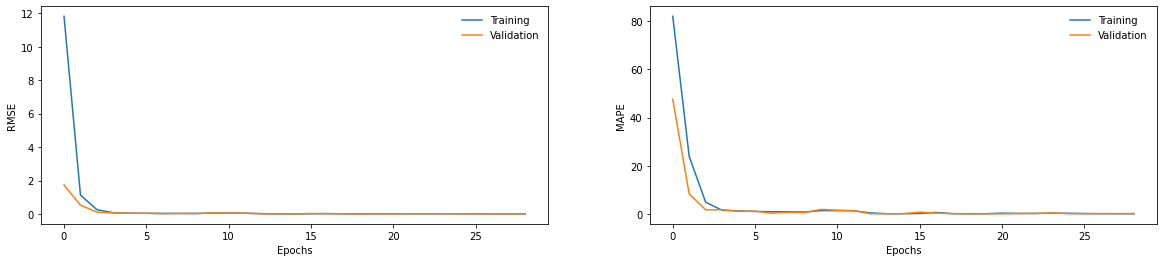

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 4))

ax[0].plot( score.history['RMSE']     );
ax[0].plot( score.history['val_RMSE'] );
ax[0].legend(['Training', 'Validation'], frameon=False);
ax[0].set_xlabel('Epochs');
ax[0].set_ylabel('RMSE');

ax[1].plot( score.history['MAPE']     );
ax[1].plot( score.history['val_MAPE'] );
ax[1].legend(['Training', 'Validation'], frameon=False);
ax[1].set_xlabel('Epochs');
ax[1].set_ylabel('MAPE');

## Load (Optimized) forecasting model

In [18]:
# Load the best model
#
model.load_weights('models/LSTM-AE.hdf5')

# Evaluation

## Get predictions

In [19]:
y_pred = model.predict( testX ).squeeze(-1)

## Calculate Performance on Testing set - Prediction visualization 

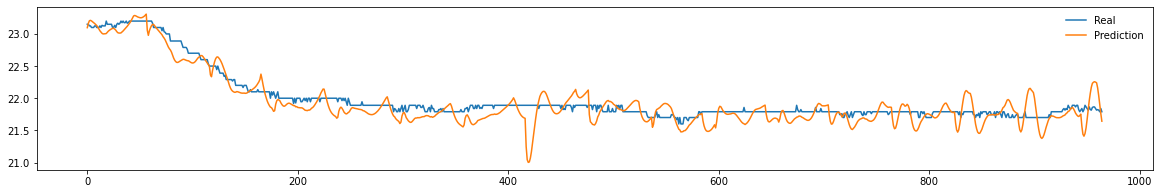

Horizon =  1
-------------
MAE   = 0.128
RMSE  = 0.164
SMAPE = 0.586
R2    = 0.838




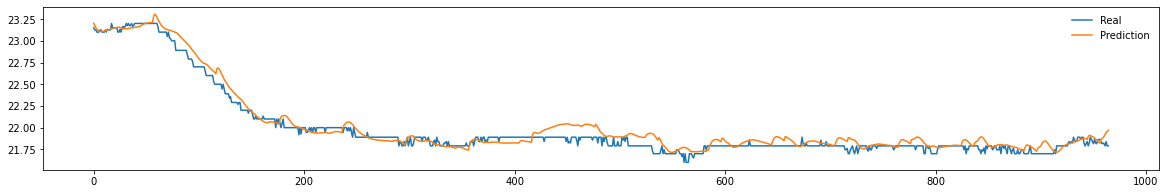

Horizon =  2
-------------
MAE   = 0.060
RMSE  = 0.076
SMAPE = 0.273
R2    = 0.964




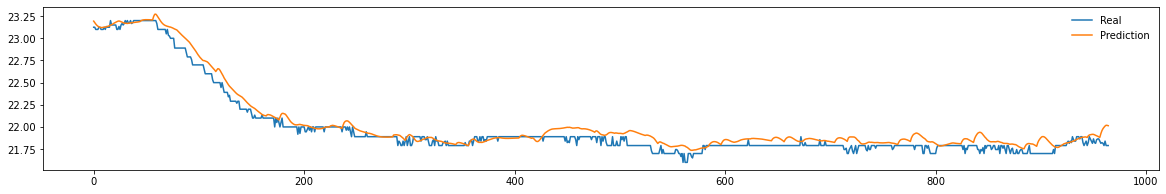

Horizon =  3
-------------
MAE   = 0.067
RMSE  = 0.083
SMAPE = 0.302
R2    = 0.957




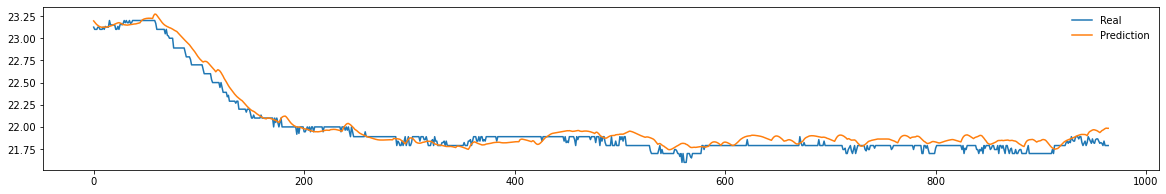

Horizon =  4
-------------
MAE   = 0.070
RMSE  = 0.084
SMAPE = 0.318
R2    = 0.956




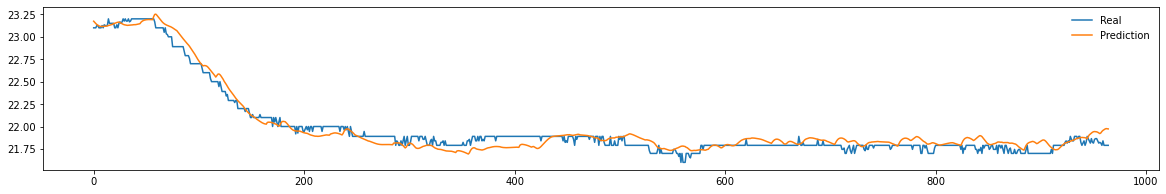

Horizon =  5
-------------
MAE   = 0.064
RMSE  = 0.077
SMAPE = 0.291
R2    = 0.963




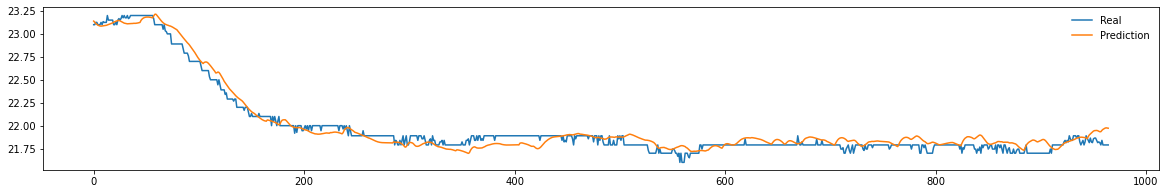

Horizon =  6
-------------
MAE   = 0.062
RMSE  = 0.075
SMAPE = 0.281
R2    = 0.965




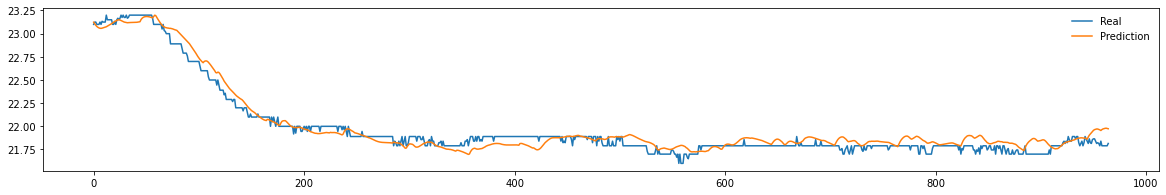

Horizon =  7
-------------
MAE   = 0.065
RMSE  = 0.079
SMAPE = 0.297
R2    = 0.960




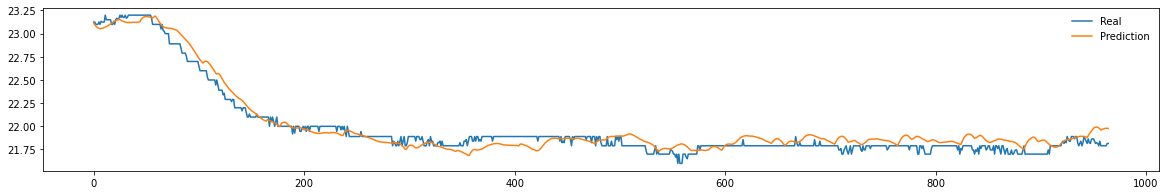

Horizon =  8
-------------
MAE   = 0.072
RMSE  = 0.086
SMAPE = 0.327
R2    = 0.953




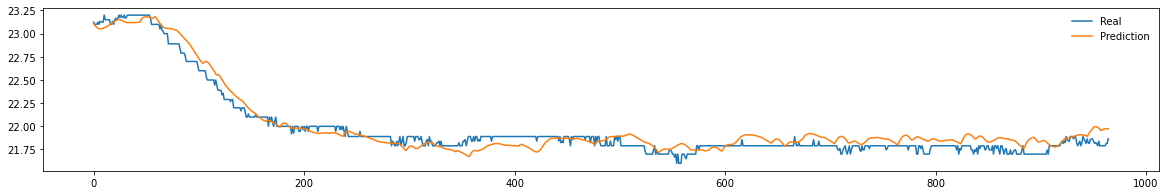

Horizon =  9
-------------
MAE   = 0.075
RMSE  = 0.089
SMAPE = 0.342
R2    = 0.948




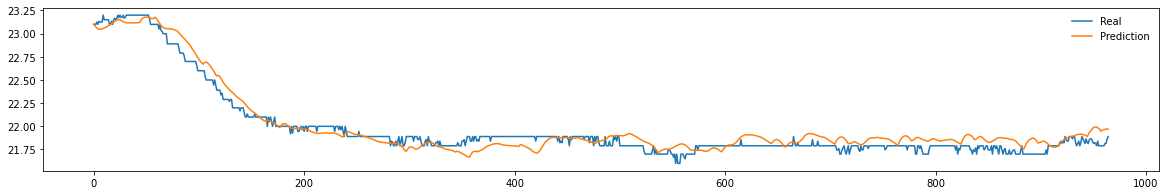

Horizon =  10
-------------
MAE   = 0.076
RMSE  = 0.091
SMAPE = 0.347
R2    = 0.946




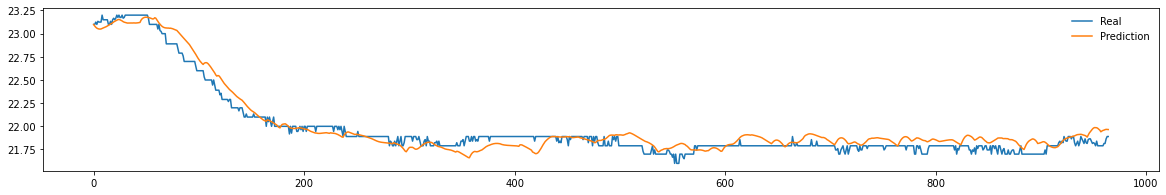

Horizon =  11
-------------
MAE   = 0.076
RMSE  = 0.092
SMAPE = 0.347
R2    = 0.945




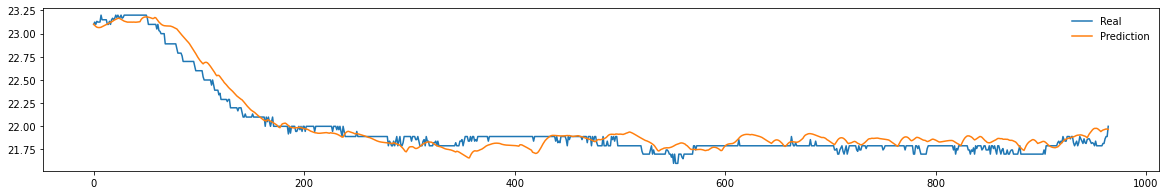

Horizon =  12
-------------
MAE   = 0.078
RMSE  = 0.095
SMAPE = 0.354
R2    = 0.940




In [20]:
Performance_Foresting_Model = {'Horizon': [], 'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):
    
    Prices = pd.DataFrame([])        
    
    Prices['Real']       = testY[:, i]
    Prices['Prediction'] = y_pred[:, i]


    # Apply inverse transformation   
    #
    if (Transformation == 'Log'):
        Prices = np.exp( Prices )
        
    elif (Transformation == 'yeo-johnson'):
        Prices['Real']       = transformer.inverse_transform( Prices['Real'] )
        Prices['Prediction'] = transformer.inverse_transform( Prices['Prediction'] )
        
    elif (Transformation == 'box-cox'):
        Prices['Real']       = transformer.inverse_transform( Prices['Real'] )
        Prices['Prediction'] = transformer.inverse_transform( Prices['Prediction'] )        
    
    
    
    
    # Plot Real & Predicted values
    #
    Prices.plot( figsize = (20, 3) )
    #
    plt.legend( frameon = False )
    plt.show()
    
    
    
    
    
    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    
    # Store results (Performance metrics)
    #
    Performance_Foresting_Model['Horizon'] += [ i+1 ]
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE  ]
    Performance_Foresting_Model['MAE']     += [ MAE   ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE ]
    Performance_Foresting_Model['R2']      += [ R2    ]
    
    
    # Export results
    print('Horizon = ', i+1)
    print('-------------')
    print('MAE   = %.3f' % MAE)
    print('RMSE  = %.3f' % RMSE)
    print('SMAPE = %.3f' % SMAPE)
    print('R2    = %.3f' % R2)
    print('\n')



Performance_Foresting_Model = pd.DataFrame( Performance_Foresting_Model )
Performance_Foresting_Model.set_index('Horizon', inplace=True)

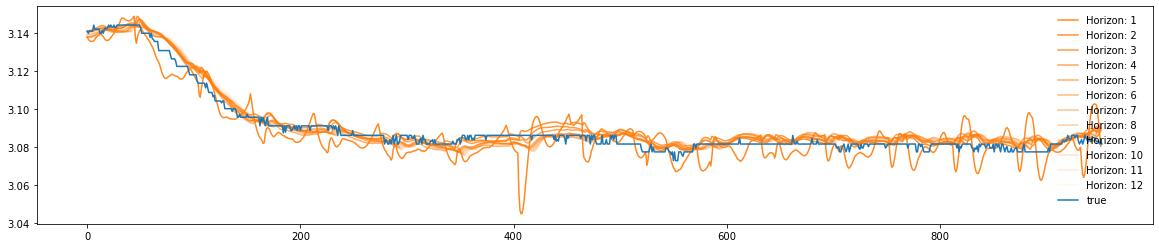

In [21]:
plt.figure(figsize=(20, 4))

for t_h in range(Horizon):
    plt.plot(y_pred[(Horizon-t_h):-(t_h+1),t_h], color = 'tab:orange', alpha = 1-1/(Horizon+1)*(t_h+1), label='Horizon: {}'.format(t_h+1))

plt.plot(testY[Horizon:,0], color = 'tab:blue', label='true')

plt.legend(frameon=False); 
plt.show();